# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import cm
from math import log, e
import random
import sys
import os
import matplotlib.image as mpimg
from IPython.core.display import Image, display
from tqdm import tqdm_notebook
from six.moves import reload_module

### Custom Libraries

In [2]:
from density_tree.decision_tree_create import *
from density_tree.density_tree_create import *
from density_tree.density_tree import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generic Functions
The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


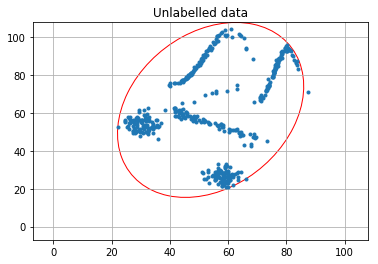

In [31]:
dimensions = 2
nclusters = 5
covariance =  [10, 10]
npoints = 100
minRange = 10
maxRange = 100

dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                                labelled = False, random_flip=True, nonlinearities = True)

m = np.mean(dataset, axis = 0)
cov = np.cov(dataset.T)
figure, axes = plt.subplots(nrows = 1, ncols = 1)
plot_data(dataset, "Unlabelled data", axes, labels=False, covs=[cov], means=[m])
plt.show()

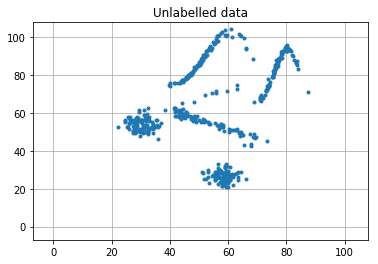

In [32]:
figure, axes = plt.subplots(nrows = 1, ncols = 1)
plot_data(dataset, "Unlabelled data", axes, labels=False)
plt.show()

For tree descent, we have to decide how many clusters we want to produce (limit depth) or what should be the threshold of information gain for the algorithm to stop (information gain limit)

In [33]:
root = create_density_tree(dataset, dimensions = 2, clusters = nclusters)

/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/cyrilwendl/Documents/EPFL/SIE-Project/Code/density_tree/helpers.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
  k = np.linalg.det(np.cov(dataset.T))
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = 

In [34]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals)[np.not_equal(cut_vals,None)].astype(float)
cut_dims = np.asarray(cut_dims)[np.not_equal(cut_dims,None)].astype(int)

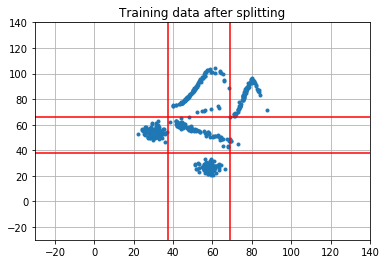

In [35]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

fig, ax = plt.subplots(1,1)
plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split, 
                            minrange = minRange, maxrange = maxRange, covariance=covariance)

%clear
plt.show()

In [36]:
print(cut_dims, cut_vals)

[1 1 0 0] [ 37.8071419   65.79636198  37.59318837  68.71967719]


# Printing the Tree

In [37]:
tree_string = ""
tree_string = print_density_tree_latex(root,tree_string)
tree_string

'[1$<$37.8[ent:7.02][1$<$65.8[0$<$37.6[ent:7.36][ent:7.92]][0$<$68.7[ent:9.63][ent:8.32]]]]'

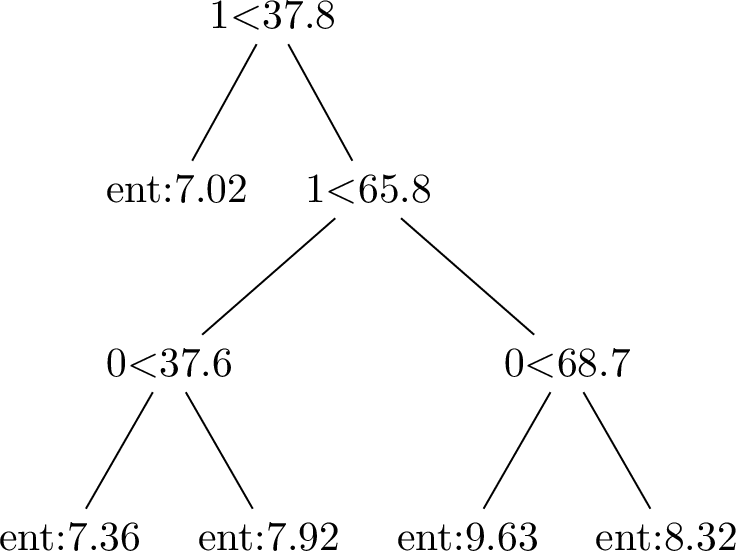

In [38]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root,tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;  echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; /Library/TeX/texbin/pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

#### Showing all Clusters Covariances

In [39]:
covs = []
means = []
def get_clusters(node):
    """add all leaf nodes to an array in preorder traversal fashion"""
    # check for leaf node
    if node.left is not None:
        get_clusters(node.left)
    else:
        covs.append(node.left_cov)
        means.append(node.left_mean)
    if node.right is not None:
        get_clusters(node.right)  
    else:
        covs.append(node.right_cov)
        means.append(node.right_mean)
        
        
get_clusters(root)

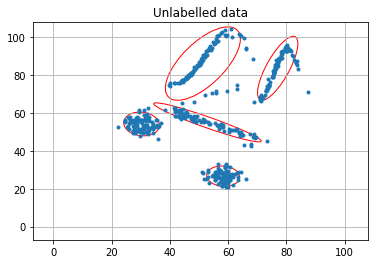

In [40]:
figure, axes = plt.subplots(nrows = 1, ncols = 1)
plot_data(dataset, "Unlabelled data", axes, labels=False, covs=covs, means=means)
plt.show()